In [1]:
import numpy as np
import pandas as pd
import argparse
import glob
import os
import json
from scipy import stats

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from custom_dataset_embed import CustomDataset
from custom_dataset_smri_gene import CustomDataset as CD
from network_genes import Network as Network_g,ContrastiveLearning
from network_smri import Network as Network_smmri
from network_imaging import Network as Network_imaging

from sklearn.model_selection import StratifiedShuffleSplit

from matplotlib import pyplot as plt

from nilearn.image import load_img,resample_img
import nibabel as nib

import requests

In [28]:
parser = argparse.ArgumentParser()
parser.add_argument('--job_id',type=str,required=False)
# 5379443
parser.add_argument('--load_from',type=str,required=False,default='5416836')
args,_ = parser.parse_known_args()
print(args)
print(args.job_id)
print('number of gpus ',torch.cuda.device_count())

Namespace(job_id=None, load_from='5416836')
None
number of gpus  1


In [29]:
torch.manual_seed(52)
np.random.seed(52)
# number of subprocesses to use for data loading
num_workers = 5
# how many samples per batch to load
batch_size = 5000

test_data = CustomDataset(train=False,valid=False)


sampler = SubsetRandomSampler(list(range(len(test_data.vars))))

train_loader = DataLoader(test_data,batch_size=batch_size, 
                            sampler= sampler, num_workers=num_workers)

In [4]:
test_data.vars.new_score.value_counts()

new_score
0    3192
1    1803
Name: count, dtype: int64

In [5]:
smri_model = Network_smmri()
gene_model = Network_g()

check_point = glob.glob(f'./tb_logs/{args.load_from}/version_0/checkpoints/*.ckpt')[0]

model = ContrastiveLearning.load_from_checkpoint(check_point,
                                                smri_network = smri_model,
                                                gene_network = gene_model
                                            )

In [2]:
# Getting the original predictions
arrays = np.load('cca_arrays.npz')
X_train = arrays['X_train']
X_valid = arrays['X_valid']
X_test = arrays['X_test']
Z_train = arrays['Z_train']
Z_valid = arrays['Z_valid']
Z_test =  arrays['Z_test']
X_original = np.vstack([X_train,X_valid,X_test])
Z_original = np.vstack([Z_train,Z_valid,Z_test])

In [3]:
weights = np.load('./sparse_cca_weights.npz')

In [4]:
weights = weights['arr_0']
smri_CCA_componets = weights[0]
gene_CCA_components = weights[1]

### plotting all the component weights

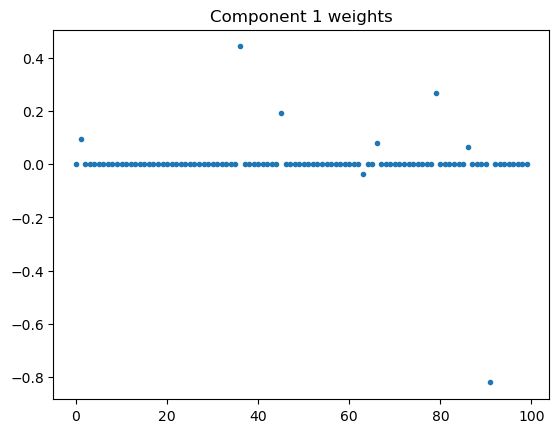

In [5]:
plt.title('Component 1 weights')
plt.plot(smri_CCA_componets[:,0],'.')

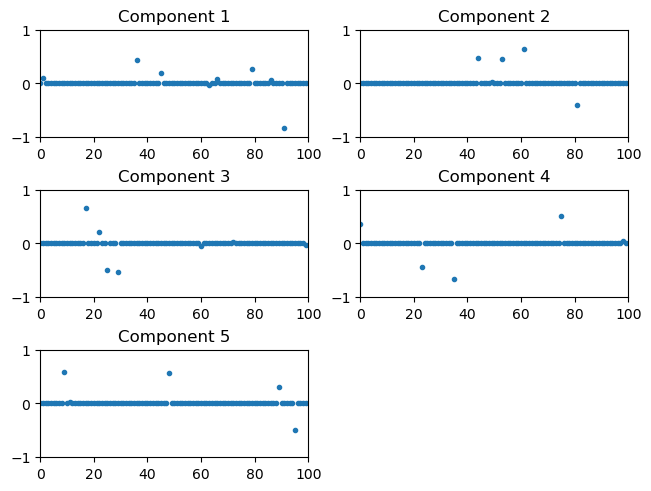

In [6]:
fig,axs = plt.subplots(3,2,layout='constrained')
fig.delaxes(axs[2][1])
plt.setp(axs, ylim=(-1,1), xlim=(0,100))

ax= axs[0][0]
ax.plot(smri_CCA_componets[:,0],'.')
ax.set_title('Component 1')

ax= axs[0][1]
ax.plot(smri_CCA_componets[:,1],'.')
ax.set_title('Component 2')

ax= axs[1][0]
ax.plot(smri_CCA_componets[:,2],'.')
ax.set_title('Component 3')

ax= axs[1][1]
ax.plot(smri_CCA_componets[:,3],'.')
ax.set_title('Component 4')

ax= axs[2][0]
ax.plot(smri_CCA_componets[:,4],'.')
ax.set_title('Component 5')
plt.draw()

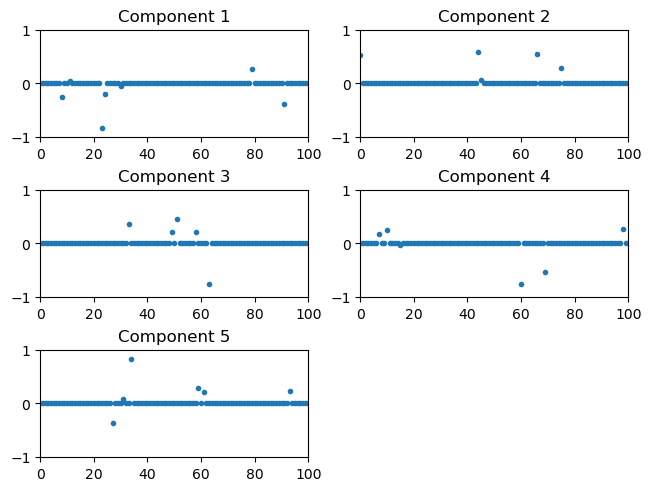

In [19]:
fig,axs = plt.subplots(3,2,layout='constrained')
fig.delaxes(axs[2][1])
plt.setp(axs, ylim=(-1,1), xlim=(0,100))

ax= axs[0][0]
ax.plot(gene_CCA_components[:,0],'.')
ax.set_title('Component 1')

ax= axs[0][1]
ax.plot(gene_CCA_components[:,1],'.')
ax.set_title('Component 2')

ax= axs[1][0]
ax.plot(gene_CCA_components[:,2],'.')
ax.set_title('Component 3')

ax= axs[1][1]
ax.plot(gene_CCA_components[:,3],'.')
ax.set_title('Component 4')

ax= axs[2][0]
ax.plot(gene_CCA_components[:,4],'.')
ax.set_title('Component 5')
plt.draw()

In [7]:
np.argmax(np.abs(smri_CCA_componets[:,0]))

91

In [ ]:
plt.plot(smri_CCA_componets[:,0],'.')

### Calculating important SNP for Component 1 to 5

In [8]:
np.argmax(np.abs(gene_CCA_components[:,0]))

23

In [9]:

# Array to store all the mean differences b/w orinal reperesentation and zeroed-out representation
# Each index represents the effect of removing that snp on the model output of the imp_repr 
#(imp based on the abs weight from the cca component)
SNP_contributions_per_component = {} # Key: component number, Value: array
for i in range(5):
    # computing the important representation index based on the highest CCA weight
    imp_repr = np.argmax(np.abs(gene_CCA_components[:,i]))
    SNP_contributions_per_component[i] = []
    # zero each of 1060 SNP and compute the model output
    for X_gene,X_smri, y,_ in train_loader:
        for j in range(X_gene.shape[1]):
            # create a copy of the tensor and zero out the SNP
            zeroed_out_genes = X_gene.clone().detach()
            zeroed_out_genes[:,j] = 0

            #perform prediction on zeroed-out input      
            pred_gene = model.gene_NN(zeroed_out_genes.to(model.device).float()).detach().cpu().numpy()

            #computing the mean difference between Z_original(non-zeroed model output) 
            # and the model output of zeroed-out input
            SNP_contributions_per_component[i].append(np.mean(Z_original[:,imp_repr] 
                                                        - pred_gene[:,imp_repr]))


In [9]:
print(test_data.gene_dataset.iloc[:,512+301].name)

NameError: name 'test_data' is not defined

In [10]:
eQTL = pd.read_csv('/data/users3/pnadigapusuresh1/Projects/ukbiobank/Data/QTL/eQTL_hg19_1FPKM_with_rs_id.csv')

In [11]:
eQTL[eQTL.rs_id == 'rs6019518']

,Unnamed: 0,gene_id,gene_chr,gene_start,gene_end,strand,number_of_SNPs_tested,SNP_distance_to_TSS,SNP_id,SNP_chr,SNP_start,SNP_end,nominal_pval,regression_slope,top_SNP,FDR,snps,rs_id
759092,759092,ENSG00000124198,chr20,47538427,47538427,+,3960,-7182,20:47531245,chr20,47531245,47531245,1.619490e-06,-0.049523,0,1.122959e-04,47531245,rs6019518
759586,759586,ENSG00000124207,chr20,47662849,47662849,+,4050,-131604,20:47531245,chr20,47531245,47531245,5.871490e-10,-0.059134,0,6.821406e-08,47531245,rs6019518
759942,759942,ENSG00000124214,chr20,47804904,47804904,+,4026,-273659,20:47531245,chr20,47531245,47531245,1.405360e-03,-0.032920,0,4.398107e-02,47531245,rs6019518
760329,760329,ENSG00000124201,chr20,47894963,47894963,+,3937,-363718,20:47531245,chr20,47531245,47531245,3.840910e-04,-0.056378,0,1.496901e-02,47531245,rs6019518


In [12]:
first_second_level_genes = pd.read_csv('first_second_level_genes.csv',index_col=0)

In [13]:
first_second_level_genes

,Unnamed: 0,gene_id,gene_chr,gene_start,gene_end,strand,number_of_SNPs_tested,SNP_distance_to_TSS,SNP_id,SNP_chr,SNP_start,SNP_end,nominal_pval,regression_slope,top_SNP,FDR,snps,rs_id
19166,19166,ENSG00000175582,chr11,73472182,73472182,+,3320,-16890,11:73455292,chr11,73455292,73455292,4.280480e-08,-0.086313,0,0.000004,73455292,rs10898940
19308,19308,ENSG00000175582,chr11,73472182,73472182,+,3320,233082,11:73705264,chr11,73705264,73705264,7.062160e-05,0.061784,0,0.003427,73705264,rs4944873
22000,22000,ENSG00000149243,chr11,75141236,75141236,+,3064,-14506,11:75126730,chr11,75126730,75126730,2.960680e-04,0.054877,0,0.011975,75126730,rs10793118
64634,64634,ENSG00000214253,chr7,100888356,100888356,+,3963,387403,7:101275759,chr7,101275759,101275759,1.020610e-03,0.041162,0,0.033945,101275759,rs6965171
90300,90300,ENSG00000158161,chr1,28415207,28415207,+,2577,-104562,1:28310645,chr1,28310645,28310645,5.119040e-04,0.144251,0,0.019101,28310645,rs141365059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100537,2100537,ENSG00000108107,chr19,55896713,55896713,+,3286,4156,19:55900869,chr19,55900869,55900869,4.528700e-04,-0.033258,0,0.017221,55900869,rs12981911
2100546,2100546,ENSG00000108107,chr19,55896713,55896713,+,3286,13519,19:55910232,chr19,55910232,55910232,8.307520e-08,-0.071469,0,0.000007,55910232,rs11673539
2111777,2111777,ENSG00000175166,chr3,184016497,184016497,+,4337,-842498,3:183173999,chr3,183173999,183173999,1.631780e-03,0.037988,0,0.049569,183173999,rs6794101
2111782,2111782,ENSG00000175166,chr3,184016497,184016497,+,4337,-77640,3:183938857,chr3,183938857,183938857,9.480040e-04,-0.038527,0,0.031945,183938857,rs4447797


In [ ]:
SNP_contributions_per_component = pd.DataFrame(SNP_contributions_per_component)

In [ ]:
SNP_contributions_per_component.to_csv('SNP_contributions_per_component.csv',index=True)

In [14]:
SNP_contributions_per_component = pd.read_csv('SNP_contributions_per_component.csv',index_col=0,)

In [15]:
SNP_contributions_per_component

,0,1,2,3,4
0,0.004896,-0.004261,0.002119,0.002888,-0.003036
1,-0.004156,0.005370,-0.004985,-0.004133,0.001675
2,0.003300,-0.004312,0.003290,0.003757,-0.002642
3,-0.003821,0.002631,-0.002365,-0.002835,0.001626
4,0.002863,-0.002808,0.001642,0.003348,-0.003055
...,...,...,...,...,...
1055,0.003638,-0.002735,0.002133,0.001030,-0.000512
1056,0.000038,0.000074,-0.000072,0.000425,-0.000225
1057,0.004383,-0.002265,0.003533,0.000991,-0.002268
1058,0.002972,-0.002463,0.001095,0.002913,-0.001994


In [16]:
comp1_snps = SNP_contributions_per_component.loc[np.abs(stats.zscore(SNP_contributions_per_component['0'],axis=0)) > 3]
comp2_snps = SNP_contributions_per_component.loc[np.abs(stats.zscore(SNP_contributions_per_component['1'],axis=0)) > 3]
comp3_snps = SNP_contributions_per_component.loc[np.abs(stats.zscore(SNP_contributions_per_component['2'],axis=0)) > 3]
comp4_snps = SNP_contributions_per_component.loc[np.abs(stats.zscore(SNP_contributions_per_component['3'],axis=0)) > 3]
comp5_snps = SNP_contributions_per_component.loc[np.abs(stats.zscore(SNP_contributions_per_component['4'],axis=0)) > 3]

In [17]:
print(gene_CCA_components[np.argmax(np.abs(gene_CCA_components[:,0])),0])
comp1_snps['0']

-0.8238225834670311


1     -0.004156
6     -0.004065
23    -0.005489
121   -0.003994
165   -0.004196
301    0.014382
451   -0.005702
493   -0.004358
575   -0.004450
727   -0.004706
868   -0.004518
964   -0.004746
995   -0.005493
Name: 0, dtype: float64

In [20]:
print(gene_CCA_components[np.argmax(np.abs(gene_CCA_components[:,1])),1])
comp2_snps['1']

0.5818093592189004


1       0.005370
6       0.003451
23      0.003281
45      0.002879
63      0.002788
299     0.003265
301    -0.010910
451     0.002842
493     0.002831
748     0.002779
868     0.003116
964     0.003212
1030    0.003722
1051    0.003629
Name: 1, dtype: float64

In [21]:
print(gene_CCA_components[np.argmax(np.abs(gene_CCA_components[:,2])),2])
comp3_snps['2']

-0.7529525183833125


1      -0.004985
14     -0.003111
23     -0.003241
301     0.007901
374    -0.003368
451    -0.003572
493    -0.005180
748    -0.004188
850    -0.003365
868    -0.004185
930    -0.003369
995    -0.005073
1051   -0.003189
Name: 2, dtype: float64

In [22]:
print(gene_CCA_components[np.argmax(np.abs(gene_CCA_components[:,3])),3])
comp4_snps['3']

-0.7474782583898105


1      -0.004133
3      -0.002835
23     -0.003138
57     -0.002871
199    -0.003360
299    -0.002840
301     0.009220
493    -0.002919
514     0.007708
552    -0.002961
569    -0.002985
575    -0.004002
727    -0.004113
1030   -0.003096
Name: 3, dtype: float64

In [23]:
print(gene_CCA_components[np.argmax(np.abs(gene_CCA_components[:,4])),4])
comp5_snps['4']

0.8252688706353688


20      0.003253
23      0.003302
45      0.002959
132     0.002461
299     0.002775
301    -0.006311
493     0.003188
569     0.002653
727     0.003504
964     0.002424
1030    0.002177
Name: 4, dtype: float64

In [24]:
gene_names = {'ENSG00000010278':'CD9',
'ENSG00000133101':	'CCNA1',
'ENSG00000185933':	'CALHM1',
'ENSG00000054793':	'ATP9A',
'ENSG00000010810':	'FYN',
'ENSG00000023191':	'RNH1',
'ENSG00000108107':	'RPL28',
'ENSG00000168958':	'MFF',
'ENSG00000185272':	'RBM11',
'ENSG00000186868':	'MAPT',
'ENSG00000149243':	'KLHL35',
'ENSG00000138449':	'SLC40A1',
'ENSG00000131149':	'GSE1',
'ENSG00000136717':	'BIN1',
'ENSG00000159200':	'RCAN1',
'ENSG00000137845':	'ADAM10',
'ENSG00000082701':	'GSK3B',
'ENSG00000124214':	'STAU1',
'ENSG00000188906':	'LRRK2',
'ENSG00000064726':	'BTBD1',
'ENSG00000175582':	'RAB6A',
'ENSG00000214253':	'FIS1',
'ENSG00000166582':	'CENPV'}

In [45]:
def get_geneids(i=0,*snps):
    final_snps = []
    rs_ids = []
    gene_ids = []
    for _,arg in enumerate(snps):
        indices = arg[f'{i}'].sort_values(ascending=False,key=np.abs).index.tolist()
        final_snps.extend(indices)
    
    print(len(final_snps))
    for snp_index in final_snps:
        rs_id = test_data.gene_dataset.columns[512+snp_index]
        qtls = eQTL[eQTL.rs_id == rs_id]
        if qtls.shape[0] > 1:
            snp = qtls[qtls.gene_id.isin(first_second_level_genes.gene_id.tolist())].gene_id.tolist()
            rs = qtls[qtls.gene_id.isin(first_second_level_genes.gene_id.tolist())].rs_id.tolist()
        else:
            snp = qtls.gene_id.tolist()
            rs = qtls.rs_id.tolist()
        gene_ids.extend(snp)
        rs_ids.extend(rs)
        
    return rs_ids,gene_ids,final_snps

In [48]:
final_snps, significant_gene_ids,snp_ids = get_geneids(1,comp2_snps)
for pos,i in enumerate(significant_gene_ids):
    print(i,gene_names[i],snp_ids[pos])

13
ENSG00000124214 STAU1 301
ENSG00000137845 ADAM10 451
ENSG00000188906 LRRK2 995
ENSG00000214253 FIS1 23
ENSG00000188906 LRRK2 964
ENSG00000023191 RNH1 727
ENSG00000010278 CD9 868
ENSG00000136717 BIN1 575
ENSG00000064726 BTBD1 493
ENSG00000082701 GSK3B 165
ENSG00000175582 RAB6A 1
ENSG00000175582 RAB6A 6
ENSG00000185272 RBM11 121


In [42]:
final_snps

['rs6019518']

In [113]:
final_snps, significant_gene_ids = get_geneids(comp1_snps,
                           comp2_snps,
                           comp3_snps,
                           comp4_snps,
                           comp5_snps)
len(significant_gene_ids)

65


28

In [114]:
for i in set(significant_gene_ids):
    print(i)

ENSG00000010278
ENSG00000133101
ENSG00000185933
ENSG00000054793
ENSG00000010810
ENSG00000023191
ENSG00000108107
ENSG00000168958
ENSG00000185272
ENSG00000186868
ENSG00000149243
ENSG00000138449
ENSG00000131149
ENSG00000136717
ENSG00000159200
ENSG00000137845
ENSG00000082701
ENSG00000124214
ENSG00000188906
ENSG00000064726
ENSG00000175582
ENSG00000214253
ENSG00000166582


In [117]:
for k,v in gene_names.items():
    print(v)

CD9
CCNA1
CALHM1
ATP9A
FYN
RNH1
RPL28
MFF
RBM11
MAPT
KLHL35
SLC40A1
GSE1
BIN1
RCAN1
ADAM10
GSK3B
STAU1
LRRK2
BTBD1
RAB6A
FIS1
CENPV


In [28]:
import requests

def get_gene_from_snp(snp_id):
    server = "https://rest.ensembl.org"
    ext = f"/variation/homo_sapiens/{snp_id}?"
    headers = {"Content-Type": "application/json"}
    response = requests.get(server + ext, headers=headers)
    if not response.ok:
        response.raise_for_status()
        return None
    return response.json()

snp_ids = list(set(final_snps))  # Example SNPs
genes = []
for snp_id in snp_ids:
    data = get_gene_from_snp(snp_id)
    if data and 'mappings' in data:
        for mapping in data['mappings']:
            if 'gene' in mapping:
                genes.append(mapping['gene']['external_name'])

print("Mapped Genes:", genes)


Mapped Genes: []


# Imaging

In [49]:
parent_directory = '/data/users3/pnadigapusuresh1/JobOutputs'
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model_smri = Network_imaging()
model_smri.fc1 = nn.Sequential(nn.Linear(512,2))
model_smri = nn.DataParallel(model_smri)
model_smri.to(device)

Using cuda device


DataParallel(
  (module): Network(
    (cv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cv4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn4): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cv5): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn5): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Sequential(
      (0): Linear(in_features=512, out_features=2, bias=Tr

In [17]:
load_path = os.path.join(parent_directory,'1818979','models_fold','5','epoch_38')
model_smri.load_state_dict(torch.load(load_path))
model_smri.eval()

DataParallel(
  (module): Network(
    (cv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cv4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn4): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cv5): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn5): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Sequential(
      (0): Linear(in_features=512, out_features=2, bias=Tr

In [51]:
batch_size = 1

valid_data = CD(train= False,valid=False)

valid_sampler = SubsetRandomSampler(range(len(valid_data)))

valid_loader = DataLoader(valid_data,batch_size=batch_size, 
                            sampler= valid_sampler, num_workers=1)

In [26]:
X_gene,X_smri,y,img = next(iter(valid_loader))

In [27]:
img.shape

torch.Size([1, 121, 145, 121])

In [2]:
imf = load_img('/trdapps/linux-x86_64/matlab/toolboxes/spm12/tpm/labels_Neuromorphometrics.nii')
aal = load_img('/data/users3/pnadigapusuresh1/Downloads/AAL3/AAL3v1.nii.gz')
aal_resampled = resample_img('/data/users3/pnadigapusuresh1/Downloads/AAL3/aal.nii.gz',target_affine=imf.affine,target_shape=imf.shape,interpolation='nearest').get_fdata()
df = pd.read_csv('/data/users3/pnadigapusuresh1/Downloads/AAL3/aal.nii.txt',sep=' ',index_col=0,header=None,usecols=[0,1],names=['value','regions'])
regions = df.to_dict()['regions']

In [3]:
imf.

array([[  -1.5,    0. ,    0. ,   90. ],
       [   0. ,    1.5,    0. , -126. ],
       [   0. ,    0. ,    1.5,  -72. ],
       [   0. ,    0. ,    0. ,    1. ]])

In [10]:
len(regions)

116

In [35]:
# Array to store all the mean differences b/w orinal reperesentation and zeroed-out representation
# Each index represents the effect of removing that snp on the model output of the imp_repr 
#(imp based on the abs weight from the cca component)
region_contributions_per_component = {} # Key: component number, Value: array
for i in range(5):
    # computing the important representation index based on the highest CCA weight
    imp_repr = np.argmax(np.abs(smri_CCA_componets[:,i]))
    region_contributions_per_component[i] = [] # num_subjects by num_region_contribution_differnce
    # zero each of 116 regions and compute the model output
    
    for j,(X_gene,X_smri, y,img) in enumerate(valid_loader):
        output_difference = [] # 1 by num_region_diff 
        for k,v in regions.items():
            # create a copy of the tensor and zero out the SNP
            region_zeroed_out_smri = img.clone().squeeze()
            region_zeroed_out_smri[aal_resampled == k] = 0
            region_zeroed_out_smri = region_zeroed_out_smri.to('cuda')
            #getting putput from CNN
            output = model_smri.module.convs(torch.unsqueeze(torch.unsqueeze(region_zeroed_out_smri,0),1).float()).flatten()
            #perform prediction on zeroed-out input      
            pred_smri = model.smri_NN(output).detach().cpu().numpy()

            #computing the mean difference between Z_original(non-zeroed model output) 
            # and the model output of zeroed-out input
            output_difference.append(X_original[j,imp_repr] 
                                                        - pred_smri[imp_repr])

        region_contributions_per_component[i].append(output_difference)



In [37]:
len(region_contributions_per_component[0])

4995

In [42]:
df_comp1 = pd.DataFrame(region_contributions_per_component[0])
df_comp2 = pd.DataFrame(region_contributions_per_component[1])
df_comp3 = pd.DataFrame(region_contributions_per_component[2])
df_comp4 = pd.DataFrame(region_contributions_per_component[3])
df_comp5 = pd.DataFrame(region_contributions_per_component[4])

In [53]:
df_comp1.to_csv('smri_regions_comp1.py',index=False)
df_comp2.to_csv('smri_regions_comp2.py',index=False)
df_comp3.to_csv('smri_regions_comp3.py',index=False)
df_comp4.to_csv('smri_regions_comp4.py',index=False)
df_comp5.to_csv('smri_regions_comp5.py',index=False)

In [45]:
mean_region_contribution_difference_per_component = pd.DataFrame([df_comp1.mean(axis=0),df_comp2.mean(axis=0),df_comp3.mean(axis=0),df_comp4.mean(axis=0),df_comp5.mean(axis=0)])

In [46]:
mean_region_contribution_difference_per_component.to_csv('mean_region_contribution_difference_per_component.csv',index=False)

In [53]:
mean_region_contribution_difference_per_component = pd.read_csv('mean_region_contribution_difference_per_component.csv')

In [54]:
comp1_regions = mean_region_contribution_difference_per_component.loc[0][np.abs(stats.zscore(mean_region_contribution_difference_per_component.loc[0])) > 2.5]
comp2_regions = mean_region_contribution_difference_per_component.loc[1][np.abs(stats.zscore(mean_region_contribution_difference_per_component.loc[1])) > 2.5]
comp3_regions = mean_region_contribution_difference_per_component.loc[2][np.abs(stats.zscore(mean_region_contribution_difference_per_component.loc[2])) > 2.5]
comp4_regions = mean_region_contribution_difference_per_component.loc[3][np.abs(stats.zscore(mean_region_contribution_difference_per_component.loc[3])) > 2.5]
comp5_regions = mean_region_contribution_difference_per_component.loc[4][np.abs(stats.zscore(mean_region_contribution_difference_per_component.loc[4])) > 2.5]



In [55]:
print(smri_CCA_componets[np.argmax(np.abs(smri_CCA_componets[:,0])),0])
comp1_regions.sort_values(ascending=False,key=np.abs)

-0.8207150317711375


97    0.410476
29    0.282070
73    0.274807
71    0.271180
Name: 0, dtype: float64

In [56]:
print(smri_CCA_componets[np.argmax(np.abs(smri_CCA_componets[:,1])),1])
comp2_regions.sort_values(ascending=False,key=np.abs)

0.6314120784397501


54    0.207437
71   -0.198324
46    0.179838
Name: 1, dtype: float64

In [35]:
print(smri_CCA_componets[np.argmax(np.abs(smri_CCA_componets[:,2])),2])
comp3_regions.sort_values(ascending=False,key=np.abs)

0.6569575103239135


97   -0.318505
29   -0.260786
71   -0.250690
Name: 2, dtype: float64

In [41]:
print(smri_CCA_componets[np.argmax(np.abs(smri_CCA_componets[:,3])),3])
comp4_regions.sort_values(ascending=False,key=np.abs)

-0.6535019266923962


85   -0.166545
46   -0.153325
71    0.074070
Name: 3, dtype: float64

In [37]:
print(smri_CCA_componets[np.argmax(np.abs(smri_CCA_componets[:,4])),4])
comp5_regions.sort_values(ascending=False,key=np.abs)

0.5791828058288054


54    0.167906
46    0.153276
71   -0.142884
Name: 4, dtype: float64

In [32]:
# function that takes the component regions and returns the top regions
def get_regions(*args):
    rs = []
    for arg in args:
        top_regions = arg.sort_values(ascending=False,key=np.abs).index.to_list()
        rs.extend(top_regions)
    print(rs)

    return [(r, regions[int(r)]) for r in rs]

In [41]:
region = get_regions(comp5_regions)
for r in region:
    print(r[1])

['54', '46', '71']
Occipital_Inf_R
Cuneus_R
Caudate_L


In [44]:
region = get_regions(comp1_regions,comp2_regions,comp3_regions,comp4_regions,comp5_regions)

['97', '29', '73', '71', '54', '71', '46', '97', '29', '71', '85', '46', '71', '54', '46', '71']


In [45]:
set(region)

{('29', 'Insula_L'),
 ('46', 'Cuneus_R'),
 ('54', 'Occipital_Inf_R'),
 ('71', 'Caudate_L'),
 ('73', 'Putamen_L'),
 ('85', 'Temporal_Mid_L'),
 ('97', 'Cerebelum_4_5_L')}

#### plotting brain images

In [92]:
def get_nii(component,component_number):
    
    direction = smri_CCA_componets[np.argmax(np.abs(smri_CCA_componets[:,component_number])),component_number]
    direction = 1 if direction > 0 else -1
    comp1_nii = np.zeros_like(aal_resampled)

    for i in component.keys():
        comp1_nii[aal_resampled == int(i)] = component.get(i) * direction

    return nib.Nifti1Image(comp1_nii, affine=imf.affine)  

In [93]:
get_nii(comp1_regions,0).to_filename('component1.nii')
get_nii(comp2_regions,1).to_filename('component2.nii')
get_nii(comp3_regions,2).to_filename('component3.nii')
get_nii(comp4_regions,3).to_filename('component4.nii')
get_nii(comp5_regions,4).to_filename('component5.nii')

In [94]:
c1 = nib.load('component1.nii').get_fdata()

In [86]:
comp1_nii = np.zeros_like(aal_resampled)
for i in comp1_regions.keys():
    comp1_nii[aal_resampled == int(i)] = comp1_regions.get(i) * -1

In [88]:
comp1_nii.min()

-0.41047645

In [ ]:
comp1